In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Detekcja urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Urządzenie: {device}")

# Ścieżki
base_dir = '../tiny-imagenet-200'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val', 'images')
test_dir = os.path.join(base_dir, 'test', 'images')

# Transformacje
transform_train = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_valtest = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasety
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_valtest)

# Dla testu (brak etykiet)
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset
class TinyImageNetTest(Dataset):
    def __init__(self, root, transform=None):
        self.paths = sorted([os.path.join(root, fname) for fname in os.listdir(root) if fname.endswith('.JPEG')])
        self.transform = transform
        self.loader = default_loader
    def __getitem__(self, index):
        img = self.loader(self.paths[index])
        if self.transform:
            img = self.transform(img)
        return img, self.paths[index].split('/')[-1]  # zwracamy nazwę pliku
    def __len__(self):
        return len(self.paths)

test_dataset = TinyImageNetTest(test_dir, transform=transform_valtest)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} obrazów w {len(train_dataset.classes)} klasach")
print(f"Val:   {len(val_dataset)} obrazów w {len(val_dataset.classes)} klasach")
print(f"Test:  {len(test_dataset)} obrazów (bez etykiet)")


Urządzenie: cuda
Train: 100000 obrazów w 200 klasach
Val:   10000 obrazów w 200 klasach
Test:  10000 obrazów (bez etykiet)


1. n03160309
2. n02279972
3. n07768694
4. n03804744
5. n02481823
6. n02481823
7. n03733131
8. n02504458


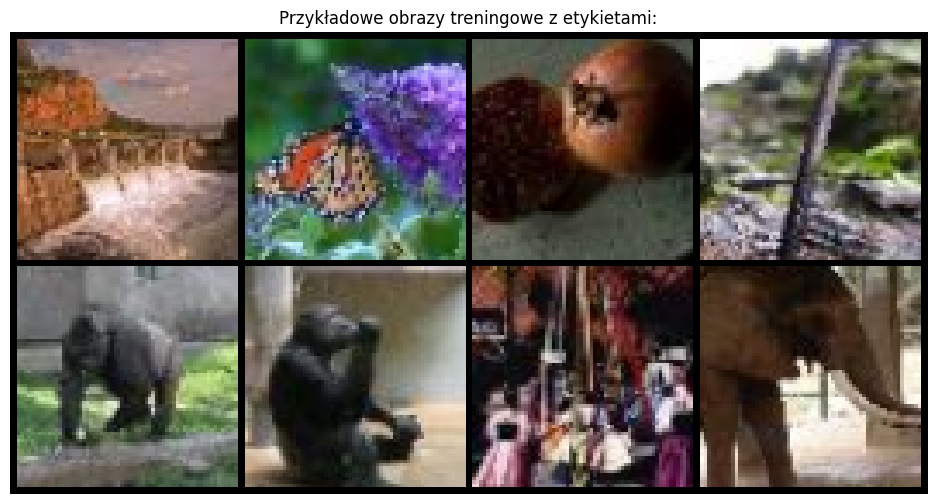

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Funkcja do denormalizacji obrazu
def denormalize(tensor, mean, std):
    tensor = tensor.clone().cpu()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Wyświetlenie batcha obrazów
def show_batch(data_loader, class_names, mean, std, n_images=8):
    images, labels = next(iter(data_loader))
    images = images[:n_images]
    labels = labels[:n_images]

    images = [denormalize(img, mean, std) for img in images]
    grid = torchvision.utils.make_grid(images, nrow=4)
    npimg = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 6))
    plt.imshow(np.clip(npimg, 0, 1))
    plt.axis('off')
    plt.title("Przykładowe obrazy treningowe z etykietami:")
    for i, label in enumerate(labels):
        print(f"{i+1}. {class_names[label]}")
    plt.show()

# Parametry normalizacji
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Wyświetlenie batcha z train_loader
show_batch(train_loader, train_dataset.classes, mean, std)



In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet18Lite(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)



🟢 Epoka 1/20


Train Loss: 4.4484 | Acc: 0.0793
Val   Loss: 4.2816 | Acc: 0.1097

🟢 Epoka 2/20


Train Loss: 3.6454 | Acc: 0.1854
Val   Loss: 3.9752 | Acc: 0.1534

🟢 Epoka 3/20


Train Loss: 3.2590 | Acc: 0.2533
Val   Loss: 4.0919 | Acc: 0.1642

🟢 Epoka 4/20


Train Loss: 2.9780 | Acc: 0.3034
Val   Loss: 3.3630 | Acc: 0.2467

🟢 Epoka 5/20


Train Loss: 2.7436 | Acc: 0.3476
Val   Loss: 3.1300 | Acc: 0.2898

🟢 Epoka 6/20


Train Loss: 2.5361 | Acc: 0.3882
Val   Loss: 3.1652 | Acc: 0.2962

🟢 Epoka 7/20


Train Loss: 2.3501 | Acc: 0.4235
Val   Loss: 3.3216 | Acc: 0.2819

🟢 Epoka 8/20


Train Loss: 2.1707 | Acc: 0.4606
Val   Loss: 3.2906 | Acc: 0.2909

🟢 Epoka 9/20


Train Loss: 1.9973 | Acc: 0.4968
Val   Loss: 3.0531 | Acc: 0.3293

🟢 Epoka 10/20


Train Loss: 1.8256 | Acc: 0.5303
Val   Loss: 3.1105 | Acc: 0.3250

🟢 Epoka 11/20


Train Loss: 1.4347 | Acc: 0.6236
Val   Loss: 3.3616 | Acc: 0.3261

🟢 Epoka 12/20


Train Loss: 1.2529 | Acc: 0.6659
Val   Loss: 3.6085 | Acc: 0.3115

🟢 Epoka 13/20


Train Loss: 1.1097 | Acc: 0.6990
Val   Loss: 3.3509 | Acc: 0.3412

🟢 Epoka 14/20


Train Loss: 0.9715 | Acc: 0.7328
Val   Loss: 3.7225 | Acc: 0.3141

🟢 Epoka 15/20


Train Loss: 0.8480 | Acc: 0.7649
Val   Loss: 3.7433 | Acc: 0.3167

🟢 Epoka 16/20


Train Loss: 0.7389 | Acc: 0.7912
Val   Loss: 3.9922 | Acc: 0.3104

🟢 Epoka 17/20


Train Loss: 0.6491 | Acc: 0.8155
Val   Loss: 4.0914 | Acc: 0.3206

🟢 Epoka 18/20


Train Loss: 0.5711 | Acc: 0.8366
Val   Loss: 3.9843 | Acc: 0.3249

🟢 Epoka 19/20


Train Loss: 0.5060 | Acc: 0.8540
Val   Loss: 4.1123 | Acc: 0.3244

🟢 Epoka 20/20


Train Loss: 0.4467 | Acc: 0.8698
Val   Loss: 4.2583 | Acc: 0.3267


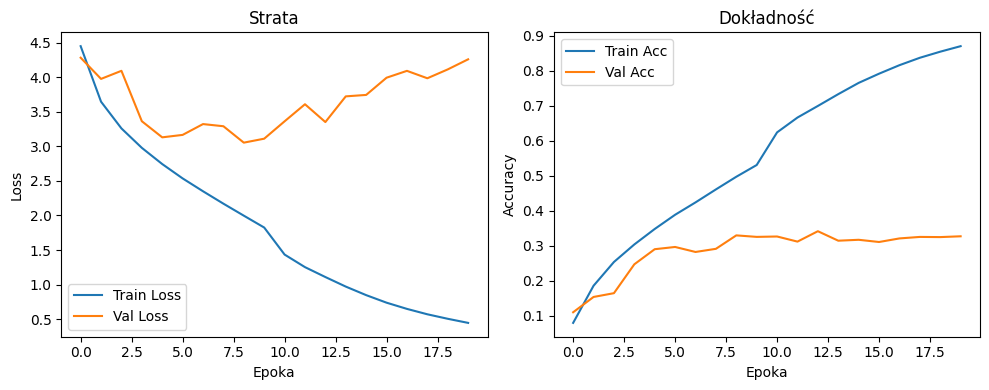

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json

# 🔧 Nazwa modelu i folder wyjściowy
model_name = "ResNet18Lite"
output_dir = f"./outputs/{model_name}"
os.makedirs(output_dir, exist_ok=True)

# 🔁 Inicjalizacja
model = ResNet18Lite(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 🧠 Funkcja treningowa
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(dataloader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

# 🧪 Funkcja walidacji
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

# 🔁 Pętla treningowa
epochs = 20
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

for epoch in range(epochs):
    print(f"\n🟢 Epoka {epoch+1}/{epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), f"{output_dir}/{model_name}_epoch{epoch+1}.pt")

# 💾 Zapis metryk
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f)

# 📈 Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.title("Strata")

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Dokładność")

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()


In [3]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from torchvision import transforms

In [8]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet18LiteV2(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


In [9]:


# Transformacje v2
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Ponowne załadowanie datasetu z nowymi augmentacjami
train_dataset.transform = transform_train

# Nowy model
model_name = "ResNet18LiteV2"
output_dir = f"./outputs/{model_name}"
os.makedirs(output_dir, exist_ok=True)

model = ResNet18LiteV2(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)



🟢 Epoka 1/20


Train Loss: 4.9004 | Acc: 0.0342
Val   Loss: 4.5300 | Acc: 0.0658
✅ Zapisano najlepszy model!

🟢 Epoka 2/20


Train Loss: 4.3538 | Acc: 0.0848
Val   Loss: 4.0961 | Acc: 0.1223
✅ Zapisano najlepszy model!

🟢 Epoka 3/20


Train Loss: 4.0618 | Acc: 0.1242
Val   Loss: 3.8843 | Acc: 0.1552
✅ Zapisano najlepszy model!

🟢 Epoka 4/20


Train Loss: 3.8608 | Acc: 0.1532
Val   Loss: 3.6191 | Acc: 0.1907
✅ Zapisano najlepszy model!

🟢 Epoka 5/20


Train Loss: 3.6934 | Acc: 0.1810
Val   Loss: 3.7727 | Acc: 0.1794

🟢 Epoka 6/20


Train Loss: 3.5545 | Acc: 0.2056
Val   Loss: 3.2818 | Acc: 0.2454
✅ Zapisano najlepszy model!

🟢 Epoka 7/20


Train Loss: 3.4155 | Acc: 0.2273
Val   Loss: 3.2592 | Acc: 0.2567
✅ Zapisano najlepszy model!

🟢 Epoka 8/20


Train Loss: 3.3074 | Acc: 0.2482
Val   Loss: 3.0917 | Acc: 0.2885
✅ Zapisano najlepszy model!

🟢 Epoka 9/20


Train Loss: 3.1957 | Acc: 0.2694
Val   Loss: 3.0424 | Acc: 0.3004
✅ Zapisano najlepszy model!

🟢 Epoka 10/20


Train Loss: 3.1026 | Acc: 0.2863
Val   Loss: 3.0769 | Acc: 0.2905

🟢 Epoka 11/20


Train Loss: 3.0109 | Acc: 0.3010
Val   Loss: 2.8842 | Acc: 0.3247
✅ Zapisano najlepszy model!

🟢 Epoka 12/20


Train Loss: 2.9222 | Acc: 0.3183
Val   Loss: 2.8435 | Acc: 0.3280
✅ Zapisano najlepszy model!

🟢 Epoka 13/20


Train Loss: 2.8366 | Acc: 0.3347
Val   Loss: 2.7754 | Acc: 0.3465
✅ Zapisano najlepszy model!

🟢 Epoka 14/20


Train Loss: 2.7583 | Acc: 0.3507
Val   Loss: 2.8090 | Acc: 0.3503
✅ Zapisano najlepszy model!

🟢 Epoka 15/20


Train Loss: 2.6862 | Acc: 0.3637
Val   Loss: 2.6159 | Acc: 0.3779
✅ Zapisano najlepszy model!

🟢 Epoka 16/20


Train Loss: 2.6104 | Acc: 0.3774
Val   Loss: 2.6490 | Acc: 0.3768

🟢 Epoka 17/20


Train Loss: 2.5529 | Acc: 0.3907
Val   Loss: 2.5709 | Acc: 0.3849
✅ Zapisano najlepszy model!

🟢 Epoka 18/20


Train Loss: 2.5101 | Acc: 0.3977
Val   Loss: 2.5487 | Acc: 0.3907
✅ Zapisano najlepszy model!

🟢 Epoka 19/20


Train Loss: 2.4766 | Acc: 0.4042
Val   Loss: 2.5262 | Acc: 0.3969
✅ Zapisano najlepszy model!

🟢 Epoka 20/20


Train Loss: 2.4568 | Acc: 0.4113
Val   Loss: 2.5302 | Acc: 0.3947


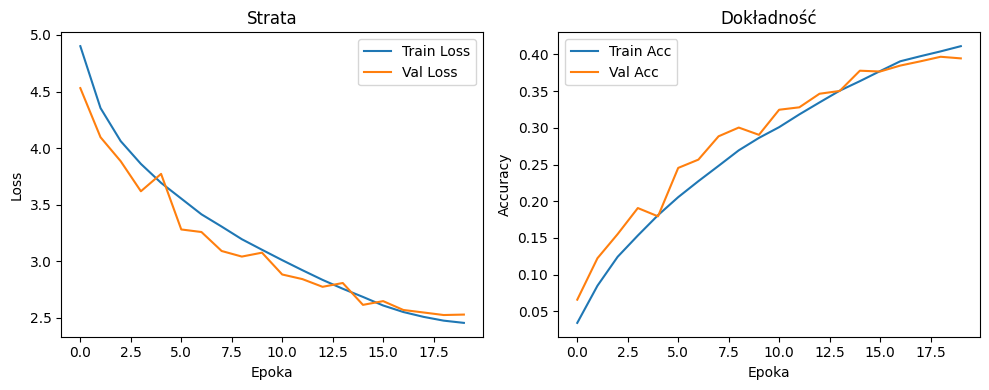

In [10]:
best_val_acc = 0.0
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

def evaluate_with_labels(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu()
            y_true.extend(labels)
            y_pred.extend(preds)
    return torch.tensor(y_true), torch.tensor(y_pred)

for epoch in range(20):
    print(f"\n🟢 Epoka {epoch+1}/20")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = total_loss / total
    train_acc = correct / total

    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    val_loss = total_loss / total
    val_acc = correct / total

    scheduler.step()

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis metryk
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f)

# Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.title("Strata")

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Dokładność")

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Macierz pomyłek na końcu
y_true, y_pred = evaluate_with_labels(model, val_loader)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d', cmap="Blues")
plt.title("Macierz pomyłek (Validation)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()


In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


In [12]:
import numpy as np

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)



🟢 Epoka 1/20


Train Loss: 5.1374 | Acc: 0.0221
Val   Loss: 4.7888 | Acc: 0.0564
✅ Zapisano najlepszy model!

🟢 Epoka 2/20


Train Loss: 4.8854 | Acc: 0.0520
Val   Loss: 4.5924 | Acc: 0.0896
✅ Zapisano najlepszy model!

🟢 Epoka 3/20


Train Loss: 4.7083 | Acc: 0.0802
Val   Loss: 4.3718 | Acc: 0.1172
✅ Zapisano najlepszy model!

🟢 Epoka 4/20


Train Loss: 4.5794 | Acc: 0.1032
Val   Loss: 4.1949 | Acc: 0.1478
✅ Zapisano najlepszy model!

🟢 Epoka 5/20


Train Loss: 4.4951 | Acc: 0.1195
Val   Loss: 4.1210 | Acc: 0.1610
✅ Zapisano najlepszy model!

🟢 Epoka 6/20


Train Loss: 4.4125 | Acc: 0.1361
Val   Loss: 3.9794 | Acc: 0.1825
✅ Zapisano najlepszy model!

🟢 Epoka 7/20


Train Loss: 4.3613 | Acc: 0.1461
Val   Loss: 3.8697 | Acc: 0.2135
✅ Zapisano najlepszy model!

🟢 Epoka 8/20


Train Loss: 4.3083 | Acc: 0.1575
Val   Loss: 3.8561 | Acc: 0.2087

🟢 Epoka 9/20


Train Loss: 4.2481 | Acc: 0.1684
Val   Loss: 3.7453 | Acc: 0.2390
✅ Zapisano najlepszy model!

🟢 Epoka 10/20


Train Loss: 4.1924 | Acc: 0.1802
Val   Loss: 3.7724 | Acc: 0.2302

🟢 Epoka 11/20


Train Loss: 4.1476 | Acc: 0.1906
Val   Loss: 3.6066 | Acc: 0.2682
✅ Zapisano najlepszy model!

🟢 Epoka 12/20


Train Loss: 4.1036 | Acc: 0.2021
Val   Loss: 3.6316 | Acc: 0.2583

🟢 Epoka 13/20


Train Loss: 4.0702 | Acc: 0.2092
Val   Loss: 3.5571 | Acc: 0.2742
✅ Zapisano najlepszy model!

🟢 Epoka 14/20


Train Loss: 4.0268 | Acc: 0.2195
Val   Loss: 3.4342 | Acc: 0.2994
✅ Zapisano najlepszy model!

🟢 Epoka 15/20


Train Loss: 3.9777 | Acc: 0.2302
Val   Loss: 3.4950 | Acc: 0.2995
✅ Zapisano najlepszy model!

🟢 Epoka 16/20


Train Loss: 3.9323 | Acc: 0.2393
Val   Loss: 3.4390 | Acc: 0.3074
✅ Zapisano najlepszy model!

🟢 Epoka 17/20


Train Loss: 3.8998 | Acc: 0.2504
Val   Loss: 3.3766 | Acc: 0.3140
✅ Zapisano najlepszy model!

🟢 Epoka 18/20


Train Loss: 3.8779 | Acc: 0.2530
Val   Loss: 3.3738 | Acc: 0.3194
✅ Zapisano najlepszy model!

🟢 Epoka 19/20


Train Loss: 3.8765 | Acc: 0.2551
Val   Loss: 3.3269 | Acc: 0.3319
✅ Zapisano najlepszy model!

🟢 Epoka 20/20


Train Loss: 3.8388 | Acc: 0.2617
Val   Loss: 3.3323 | Acc: 0.3278


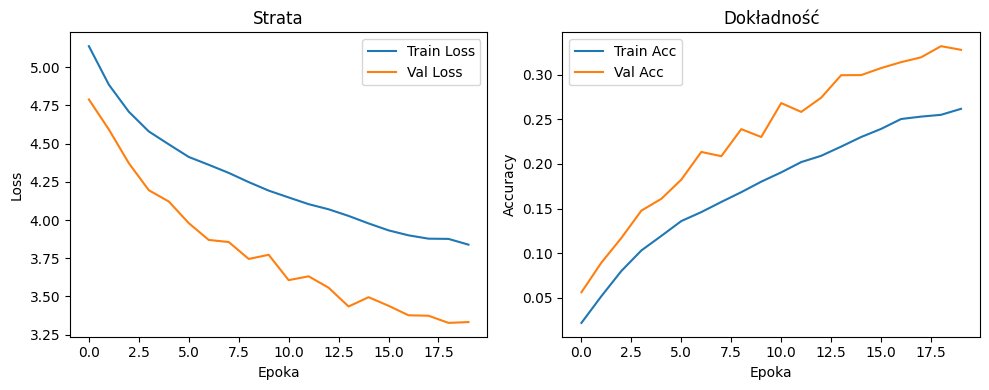

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_name = "ResNet18LiteV2_MixupLS"
output_dir = f"./outputs/{model_name}"
os.makedirs(output_dir, exist_ok=True)

model = ResNet18LiteV2(num_classes=200).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

best_val_acc = 0.0
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

def evaluate_with_labels(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu())
            y_pred.extend(preds.cpu())
    return torch.tensor(y_true), torch.tensor(y_pred)

for epoch in range(20):
    print(f"\n🟢 Epoka {epoch+1}/20")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)

        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (lam * preds.eq(targets_a).sum().item()
                   + (1 - lam) * preds.eq(targets_b).sum().item())
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)
    val_loss = total_loss / total
    val_acc = correct / total

    scheduler.step()

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis metryk
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f)

# Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.title("Strata")

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Dokładność")

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Macierz pomyłek
y_true, y_pred = evaluate_with_labels(model, val_loader)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d', cmap="Blues")
plt.title("Macierz pomyłek (Validation)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()


In [15]:
import torch.nn as nn

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        mid_channels = out_channels // 4
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)

        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)

        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(x))
        if self.downsample:
            identity = self.downsample(out)

        out = self.conv1(out)
        out = self.conv2(self.relu(self.bn2(out)))
        out = self.conv3(self.relu(self.bn3(out)))

        return self.relu(out + identity)

class CustomResNet34(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(256, blocks=3)
        self.layer2 = self._make_layer(512, blocks=4, stride=2)
        self.layer3 = self._make_layer(1024, blocks=6, stride=2)
        self.layer4 = self._make_layer(2048, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        layers = [BottleneckBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BottleneckBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


In [17]:
model_name = "CustomResNet34"
output_dir = f"./outputs/{model_name}"
os.makedirs(output_dir, exist_ok=True)

model = CustomResNet34(num_classes=200).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)



🟢 Epoka 1/20


Train Loss: 5.1661 | Acc: 0.0189
Val   Loss: 4.8862 | Acc: 0.0447
✅ Zapisano najlepszy model!

🟢 Epoka 2/20


Train Loss: 4.9297 | Acc: 0.0471
Val   Loss: 4.5044 | Acc: 0.0923
✅ Zapisano najlepszy model!

🟢 Epoka 3/20


Train Loss: 4.7246 | Acc: 0.0777
Val   Loss: 4.2993 | Acc: 0.1280
✅ Zapisano najlepszy model!

🟢 Epoka 4/20


Train Loss: 4.5779 | Acc: 0.1037
Val   Loss: 4.1877 | Acc: 0.1432
✅ Zapisano najlepszy model!

🟢 Epoka 5/20


Train Loss: 4.4668 | Acc: 0.1232
Val   Loss: 4.2770 | Acc: 0.1827
✅ Zapisano najlepszy model!

🟢 Epoka 6/20


Train Loss: 4.3860 | Acc: 0.1389
Val   Loss: 4.2034 | Acc: 0.1975
✅ Zapisano najlepszy model!

🟢 Epoka 7/20


Train Loss: 4.3088 | Acc: 0.1546
Val   Loss: 4.1962 | Acc: 0.1906

🟢 Epoka 8/20


Train Loss: 4.2385 | Acc: 0.1678
Val   Loss: 3.9214 | Acc: 0.2211
✅ Zapisano najlepszy model!

🟢 Epoka 9/20


Train Loss: 4.2119 | Acc: 0.1754
Val   Loss: 3.8536 | Acc: 0.2190

🟢 Epoka 10/20


Train Loss: 4.1733 | Acc: 0.1841
Val   Loss: 3.6983 | Acc: 0.2552
✅ Zapisano najlepszy model!

🟢 Epoka 11/20


Train Loss: 4.1158 | Acc: 0.1967
Val   Loss: 3.6774 | Acc: 0.2538

🟢 Epoka 12/20


Train Loss: 4.1081 | Acc: 0.1988
Val   Loss: 3.6208 | Acc: 0.2707
✅ Zapisano najlepszy model!

🟢 Epoka 13/20


Train Loss: 4.0474 | Acc: 0.2110
Val   Loss: 3.5805 | Acc: 0.2784
✅ Zapisano najlepszy model!

🟢 Epoka 14/20


Train Loss: 4.0312 | Acc: 0.2143
Val   Loss: 3.5045 | Acc: 0.2900
✅ Zapisano najlepszy model!

🟢 Epoka 15/20


Train Loss: 3.9656 | Acc: 0.2285
Val   Loss: 3.4982 | Acc: 0.2999
✅ Zapisano najlepszy model!

🟢 Epoka 16/20


Train Loss: 3.9573 | Acc: 0.2326
Val   Loss: 3.5085 | Acc: 0.3014
✅ Zapisano najlepszy model!

🟢 Epoka 17/20


Train Loss: 3.9167 | Acc: 0.2405
Val   Loss: 3.4918 | Acc: 0.2979

🟢 Epoka 18/20


Train Loss: 3.8986 | Acc: 0.2435
Val   Loss: 3.4796 | Acc: 0.3089
✅ Zapisano najlepszy model!

🟢 Epoka 19/20


Train Loss: 3.8877 | Acc: 0.2475
Val   Loss: 3.4697 | Acc: 0.3059

🟢 Epoka 20/20


Train Loss: 3.8824 | Acc: 0.2467
Val   Loss: 3.4616 | Acc: 0.3052


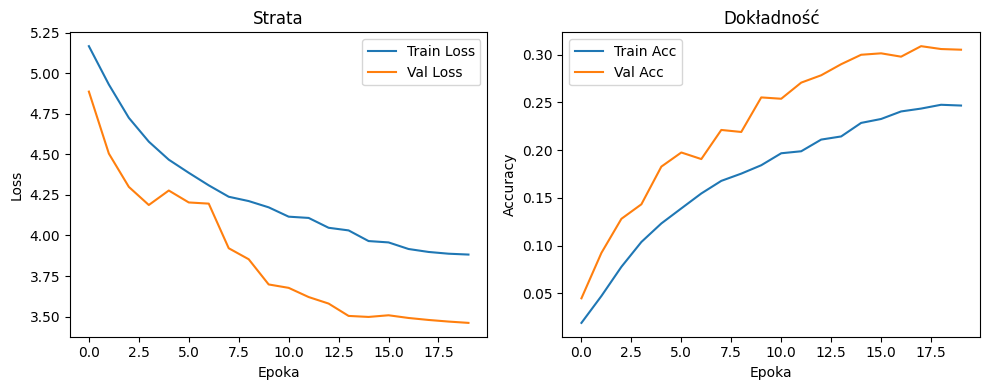

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import os

model_name = "CustomResNet34"
output_dir = f"./outputs/{model_name}"
os.makedirs(output_dir, exist_ok=True)

# Inicjalizacja modelu + optymalizatora + schedulera
model = CustomResNet34(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Mixup
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Ewaluacja z etykietami do confusion matrix
def evaluate_with_labels(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu())
            y_pred.extend(preds.cpu())
    return torch.tensor(y_true), torch.tensor(y_pred)

# Główna pętla treningowa
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0

for epoch in range(20):
    print(f"\n🟢 Epoka {epoch+1}/20")
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)

        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (lam * preds.eq(targets_a).sum().item() +
                    (1 - lam) * preds.eq(targets_b).sum().item())
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Walidacja
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total
    scheduler.step()

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis metryk
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f)

# Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Macierz pomyłek
y_true, y_pred = evaluate_with_labels(model, val_loader)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d', cmap="Blues")
plt.title("Macierz pomyłek (Validation)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()


Tenm model miał 40% trenuje go na 40 epokach

In [4]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet18LiteV2(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


In [5]:


# Transformacje v2
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Ponowne załadowanie datasetu z nowymi augmentacjami
train_dataset.transform = transform_train

# Nowy model
model_name = "ResNet18LiteV2"
output_dir = f"./outputs/{model_name}"
os.makedirs(output_dir, exist_ok=True)

model = ResNet18LiteV2(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)



🟢 Epoka 1/40


Train Loss: 4.9073 | Acc: 0.0342
Val   Loss: 4.5370 | Acc: 0.0697
✅ Zapisano najlepszy model!

🟢 Epoka 2/40


Train Loss: 4.3233 | Acc: 0.0921
Val   Loss: 3.9557 | Acc: 0.1361
✅ Zapisano najlepszy model!

🟢 Epoka 3/40


Train Loss: 4.0177 | Acc: 0.1332
Val   Loss: 3.8957 | Acc: 0.1535
✅ Zapisano najlepszy model!

🟢 Epoka 4/40


Train Loss: 3.8315 | Acc: 0.1602
Val   Loss: 3.6927 | Acc: 0.1819
✅ Zapisano najlepszy model!

🟢 Epoka 5/40


Train Loss: 3.6662 | Acc: 0.1891
Val   Loss: 3.4338 | Acc: 0.2250
✅ Zapisano najlepszy model!

🟢 Epoka 6/40


Train Loss: 3.5308 | Acc: 0.2100
Val   Loss: 3.3035 | Acc: 0.2466
✅ Zapisano najlepszy model!

🟢 Epoka 7/40


Train Loss: 3.4089 | Acc: 0.2328
Val   Loss: 3.2332 | Acc: 0.2578
✅ Zapisano najlepszy model!

🟢 Epoka 8/40


Train Loss: 3.2947 | Acc: 0.2519
Val   Loss: 3.1802 | Acc: 0.2666
✅ Zapisano najlepszy model!

🟢 Epoka 9/40


Train Loss: 3.1906 | Acc: 0.2691
Val   Loss: 3.0668 | Acc: 0.2945
✅ Zapisano najlepszy model!

🟢 Epoka 10/40


Train Loss: 3.0958 | Acc: 0.2879
Val   Loss: 2.9753 | Acc: 0.3054
✅ Zapisano najlepszy model!

🟢 Epoka 11/40


Train Loss: 3.0049 | Acc: 0.3043
Val   Loss: 2.8654 | Acc: 0.3287
✅ Zapisano najlepszy model!

🟢 Epoka 12/40


Train Loss: 2.9178 | Acc: 0.3205
Val   Loss: 2.8151 | Acc: 0.3360
✅ Zapisano najlepszy model!

🟢 Epoka 13/40


Train Loss: 2.8412 | Acc: 0.3359
Val   Loss: 2.7205 | Acc: 0.3541
✅ Zapisano najlepszy model!

🟢 Epoka 14/40


Train Loss: 2.7461 | Acc: 0.3529
Val   Loss: 2.7112 | Acc: 0.3607
✅ Zapisano najlepszy model!

🟢 Epoka 15/40


Train Loss: 2.6763 | Acc: 0.3684
Val   Loss: 2.6016 | Acc: 0.3794
✅ Zapisano najlepszy model!

🟢 Epoka 16/40


Train Loss: 2.6102 | Acc: 0.3779
Val   Loss: 2.6266 | Acc: 0.3767

🟢 Epoka 17/40


Train Loss: 2.5533 | Acc: 0.3919
Val   Loss: 2.5925 | Acc: 0.3842
✅ Zapisano najlepszy model!

🟢 Epoka 18/40


Train Loss: 2.5074 | Acc: 0.3998
Val   Loss: 2.5546 | Acc: 0.3874
✅ Zapisano najlepszy model!

🟢 Epoka 19/40


Train Loss: 2.4723 | Acc: 0.4072
Val   Loss: 2.5602 | Acc: 0.3914
✅ Zapisano najlepszy model!

🟢 Epoka 20/40


Train Loss: 2.4724 | Acc: 0.4078
Val   Loss: 2.5328 | Acc: 0.3937
✅ Zapisano najlepszy model!

🟢 Epoka 21/40


Train Loss: 2.4569 | Acc: 0.4092
Val   Loss: 2.5240 | Acc: 0.3974
✅ Zapisano najlepszy model!

🟢 Epoka 22/40


Train Loss: 2.4566 | Acc: 0.4088
Val   Loss: 2.5455 | Acc: 0.3925

🟢 Epoka 23/40


Train Loss: 2.4678 | Acc: 0.4077
Val   Loss: 2.5163 | Acc: 0.3999
✅ Zapisano najlepszy model!

🟢 Epoka 24/40


Train Loss: 2.4707 | Acc: 0.4071
Val   Loss: 2.5396 | Acc: 0.3963

🟢 Epoka 25/40


Train Loss: 2.4767 | Acc: 0.4053
Val   Loss: 2.5554 | Acc: 0.3902

🟢 Epoka 26/40


Train Loss: 2.4926 | Acc: 0.4024
Val   Loss: 2.5994 | Acc: 0.3849

🟢 Epoka 27/40


Train Loss: 2.5113 | Acc: 0.3969
Val   Loss: 2.5684 | Acc: 0.3907

🟢 Epoka 28/40


Train Loss: 2.5443 | Acc: 0.3940
Val   Loss: 2.6103 | Acc: 0.3807

🟢 Epoka 29/40


Train Loss: 2.5797 | Acc: 0.3865
Val   Loss: 2.6551 | Acc: 0.3702

🟢 Epoka 30/40


Train Loss: 2.6143 | Acc: 0.3786
Val   Loss: 2.6957 | Acc: 0.3660

🟢 Epoka 31/40


Train Loss: 2.6561 | Acc: 0.3718
Val   Loss: 2.6703 | Acc: 0.3696

🟢 Epoka 32/40


Train Loss: 2.6904 | Acc: 0.3640
Val   Loss: 2.6503 | Acc: 0.3776

🟢 Epoka 33/40


Train Loss: 2.7239 | Acc: 0.3606
Val   Loss: 2.7524 | Acc: 0.3513

🟢 Epoka 34/40


Train Loss: 2.7438 | Acc: 0.3567
Val   Loss: 2.6223 | Acc: 0.3809

🟢 Epoka 35/40


Train Loss: 2.7642 | Acc: 0.3528
Val   Loss: 2.7767 | Acc: 0.3489

🟢 Epoka 36/40


Train Loss: 2.7783 | Acc: 0.3512
Val   Loss: 2.7126 | Acc: 0.3574

🟢 Epoka 37/40


Train Loss: 2.7900 | Acc: 0.3486
Val   Loss: 2.9145 | Acc: 0.3248

🟢 Epoka 38/40


Train Loss: 2.7811 | Acc: 0.3496
Val   Loss: 2.8346 | Acc: 0.3499

🟢 Epoka 39/40


Train Loss: 2.7857 | Acc: 0.3471
Val   Loss: 2.7828 | Acc: 0.3528

🟢 Epoka 40/40


Train Loss: 2.7792 | Acc: 0.3508
Val   Loss: 2.7313 | Acc: 0.3612


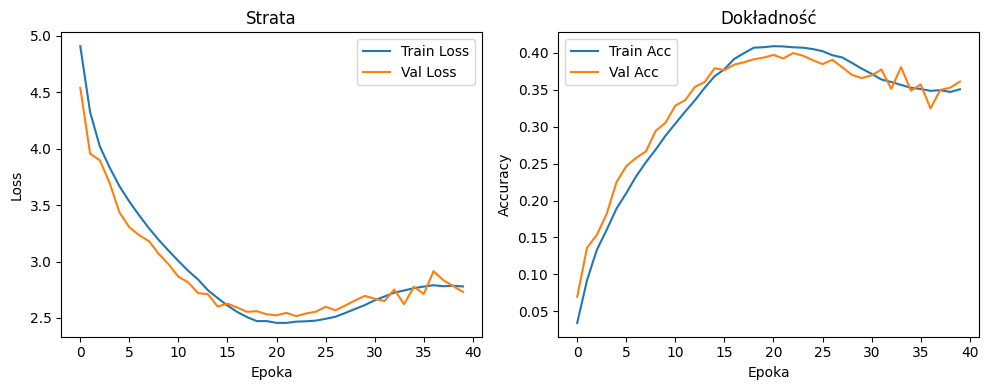

In [6]:
best_val_acc = 0.0
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

def evaluate_with_labels(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu()
            y_true.extend(labels)
            y_pred.extend(preds)
    return torch.tensor(y_true), torch.tensor(y_pred)

for epoch in range(40):
    print(f"\n🟢 Epoka {epoch+1}/40")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = total_loss / total
    train_acc = correct / total

    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    val_loss = total_loss / total
    val_acc = correct / total

    scheduler.step()

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis metryk
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f)

# Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.title("Strata")

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Dokładność")

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Macierz pomyłek na końcu
y_true, y_pred = evaluate_with_labels(model, val_loader)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d', cmap="Blues")
plt.title("Macierz pomyłek (Validation)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()


In [7]:
model_name = "ResNet18LiteV3_MixupLS_OCLR"
output_dir = f"./outputs/{model_name}"
os.makedirs(output_dir, exist_ok=True)

model = ResNet18LiteV2(num_classes=200).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=40,
    pct_start=0.1,
    div_factor=25,
    final_div_factor=100,
    anneal_strategy='cos'
)



🟢 Epoka 1/40


Train Loss: 5.2056 | Acc: 0.0211
Val   Loss: 4.7579 | Acc: 0.0606
✅ Zapisano najlepszy model!

🟢 Epoka 2/40


Train Loss: 4.8840 | Acc: 0.0553
Val   Loss: 4.5630 | Acc: 0.0851
✅ Zapisano najlepszy model!

🟢 Epoka 3/40


Train Loss: 4.7013 | Acc: 0.0809
Val   Loss: 4.4773 | Acc: 0.1163
✅ Zapisano najlepszy model!

🟢 Epoka 4/40


Train Loss: 4.5913 | Acc: 0.1017
Val   Loss: 4.1354 | Acc: 0.1594
✅ Zapisano najlepszy model!

🟢 Epoka 5/40


Train Loss: 4.4773 | Acc: 0.1250
Val   Loss: 4.1164 | Acc: 0.1598
✅ Zapisano najlepszy model!

🟢 Epoka 6/40


Train Loss: 4.3943 | Acc: 0.1404
Val   Loss: 3.8361 | Acc: 0.2154
✅ Zapisano najlepszy model!

🟢 Epoka 7/40


Train Loss: 4.3035 | Acc: 0.1588
Val   Loss: 3.8764 | Acc: 0.2074

🟢 Epoka 8/40


Train Loss: 4.2174 | Acc: 0.1779
Val   Loss: 3.7304 | Acc: 0.2404
✅ Zapisano najlepszy model!

🟢 Epoka 9/40


Train Loss: 4.1329 | Acc: 0.1948
Val   Loss: 3.7192 | Acc: 0.2483
✅ Zapisano najlepszy model!

🟢 Epoka 10/40


Train Loss: 4.0792 | Acc: 0.2066
Val   Loss: 3.6713 | Acc: 0.2568
✅ Zapisano najlepszy model!

🟢 Epoka 11/40


Train Loss: 4.0231 | Acc: 0.2208
Val   Loss: 3.4842 | Acc: 0.3084
✅ Zapisano najlepszy model!

🟢 Epoka 12/40


Train Loss: 3.9831 | Acc: 0.2323
Val   Loss: 3.4216 | Acc: 0.3161
✅ Zapisano najlepszy model!

🟢 Epoka 13/40


Train Loss: 3.9506 | Acc: 0.2408
Val   Loss: 3.4142 | Acc: 0.3178
✅ Zapisano najlepszy model!

🟢 Epoka 14/40


Train Loss: 3.9190 | Acc: 0.2484
Val   Loss: 3.3911 | Acc: 0.3233
✅ Zapisano najlepszy model!

🟢 Epoka 15/40


Train Loss: 3.8526 | Acc: 0.2634
Val   Loss: 3.3868 | Acc: 0.3228

🟢 Epoka 16/40


Train Loss: 3.8080 | Acc: 0.2757
Val   Loss: 3.2483 | Acc: 0.3507
✅ Zapisano najlepszy model!

🟢 Epoka 17/40


Train Loss: 3.7569 | Acc: 0.2866
Val   Loss: 3.2598 | Acc: 0.3581
✅ Zapisano najlepszy model!

🟢 Epoka 18/40


Train Loss: 3.7572 | Acc: 0.2895
Val   Loss: 3.1927 | Acc: 0.3668
✅ Zapisano najlepszy model!

🟢 Epoka 19/40


Train Loss: 3.6993 | Acc: 0.3023
Val   Loss: 3.1749 | Acc: 0.3792
✅ Zapisano najlepszy model!

🟢 Epoka 20/40


Train Loss: 3.6906 | Acc: 0.3071
Val   Loss: 3.1340 | Acc: 0.3929
✅ Zapisano najlepszy model!

🟢 Epoka 21/40


Train Loss: 3.6413 | Acc: 0.3177
Val   Loss: 3.1663 | Acc: 0.3844

🟢 Epoka 22/40


Train Loss: 3.6167 | Acc: 0.3261
Val   Loss: 3.3113 | Acc: 0.3746

🟢 Epoka 23/40


Train Loss: 3.5692 | Acc: 0.3364
Val   Loss: 3.1561 | Acc: 0.3926

🟢 Epoka 24/40


Train Loss: 3.5351 | Acc: 0.3448
Val   Loss: 3.1174 | Acc: 0.3915

🟢 Epoka 25/40


Train Loss: 3.5151 | Acc: 0.3504
Val   Loss: 2.9967 | Acc: 0.4186
✅ Zapisano najlepszy model!

🟢 Epoka 26/40


Train Loss: 3.4682 | Acc: 0.3610
Val   Loss: 3.1365 | Acc: 0.4049

🟢 Epoka 27/40


Train Loss: 3.4341 | Acc: 0.3689
Val   Loss: 3.0332 | Acc: 0.4237
✅ Zapisano najlepszy model!

🟢 Epoka 28/40


Train Loss: 3.4039 | Acc: 0.3787
Val   Loss: 3.0378 | Acc: 0.4219

🟢 Epoka 29/40


Train Loss: 3.4008 | Acc: 0.3813
Val   Loss: 3.0078 | Acc: 0.4328
✅ Zapisano najlepszy model!

🟢 Epoka 30/40


Train Loss: 3.3438 | Acc: 0.3943
Val   Loss: 3.0870 | Acc: 0.4161

🟢 Epoka 31/40


Train Loss: 3.3552 | Acc: 0.3932
Val   Loss: 3.0159 | Acc: 0.4354
✅ Zapisano najlepszy model!

🟢 Epoka 32/40


Train Loss: 3.3674 | Acc: 0.3919
Val   Loss: 3.0655 | Acc: 0.4331

🟢 Epoka 33/40


Train Loss: 3.2978 | Acc: 0.4061
Val   Loss: 3.0178 | Acc: 0.4326

🟢 Epoka 34/40


Train Loss: 3.2956 | Acc: 0.4086
Val   Loss: 3.1613 | Acc: 0.4311

🟢 Epoka 35/40


Train Loss: 3.3107 | Acc: 0.4048
Val   Loss: 3.1922 | Acc: 0.4328

🟢 Epoka 36/40


Train Loss: 3.2903 | Acc: 0.4110
Val   Loss: 2.9422 | Acc: 0.4425
✅ Zapisano najlepszy model!

🟢 Epoka 37/40


Train Loss: 3.2853 | Acc: 0.4122
Val   Loss: 3.1435 | Acc: 0.4277

🟢 Epoka 38/40


Train Loss: 3.2926 | Acc: 0.4104
Val   Loss: 2.9665 | Acc: 0.4386

🟢 Epoka 39/40


Train Loss: 3.2660 | Acc: 0.4183
Val   Loss: 3.0431 | Acc: 0.4402

🟢 Epoka 40/40


Train Loss: 3.3035 | Acc: 0.4085
Val   Loss: 2.9699 | Acc: 0.4435
✅ Zapisano najlepszy model!


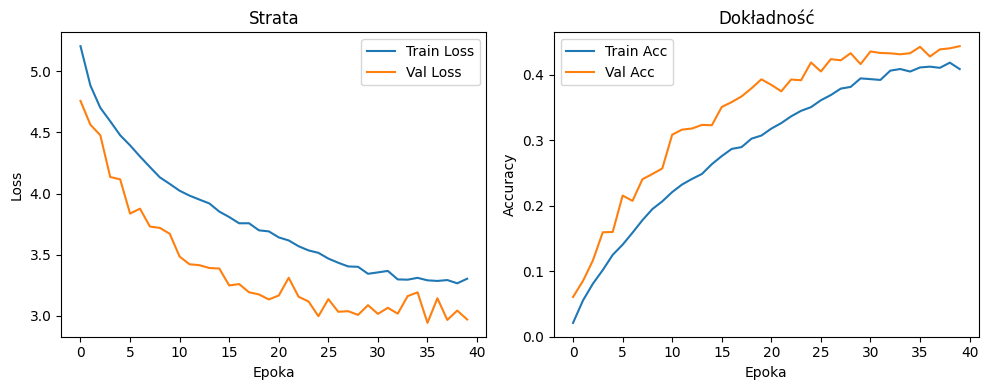

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import numpy as np

# Mixup
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Ewaluacja do macierzy pomyłek
def evaluate_with_labels(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu())
            y_pred.extend(preds.cpu())
    return torch.tensor(y_true), torch.tensor(y_pred)

# Trening
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0

for epoch in range(40):
    print(f"\n🟢 Epoka {epoch+1}/40")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)

        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (lam * preds.eq(targets_a).sum().item()
                   + (1 - lam) * preds.eq(targets_b).sum().item())
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Walidacja bez mixup
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis metryk
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f)

# Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Macierz pomyłek
y_true, y_pred = evaluate_with_labels(model, val_loader)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d', cmap="Blues")
plt.title("Macierz pomyłek (Validation)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()


In [3]:
import os, json, random, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, update_bn
from torchvision.transforms.autoaugment import RandAugment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "ResNet18V5Pro"
output_dir = f"./outputs/{model_name}"
os.makedirs(output_dir, exist_ok=True)


In [4]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        binary_tensor = torch.floor(random_tensor)
        return x.div(keep_prob) * binary_tensor

class ResidualBlockDP(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, drop_prob=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop_path = DropPath(drop_prob)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.drop_path(out)
        return self.relu(out)

class ResNet18V5Pro(nn.Module):
    def __init__(self, num_classes=200, drop_prob=0.1):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(3, 2, 1)
        self.layer1 = self._make_layer(64, 2, drop_prob)
        self.layer2 = self._make_layer(128, 2, drop_prob, stride=2)
        self.layer3 = self._make_layer(256, 2, drop_prob, stride=2)
        self.layer4 = self._make_layer(512, 2, drop_prob, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, drop_prob, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlockDP(self.in_channels, out_channels, stride, downsample, drop_prob)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlockDP(out_channels, out_channels, drop_prob=drop_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)



🟢 Epoka 1/40


Train Loss: 5.2896 | Acc: 0.0082
Val   Loss: 5.1727 | Acc: 0.0176
✅ Zapisano najlepszy model!

🟢 Epoka 2/40


Train Loss: 5.2159 | Acc: 0.0117
Val   Loss: 5.0918 | Acc: 0.0308
✅ Zapisano najlepszy model!

🟢 Epoka 3/40


Train Loss: 5.1563 | Acc: 0.0172
Val   Loss: 4.9264 | Acc: 0.0406
✅ Zapisano najlepszy model!

🟢 Epoka 4/40


Train Loss: 5.0868 | Acc: 0.0246
Val   Loss: 4.7637 | Acc: 0.0625
✅ Zapisano najlepszy model!

🟢 Epoka 5/40


Train Loss: 5.0204 | Acc: 0.0348
Val   Loss: 4.5827 | Acc: 0.1035
✅ Zapisano najlepszy model!

🟢 Epoka 6/40


Train Loss: 4.9577 | Acc: 0.0436
Val   Loss: 4.4441 | Acc: 0.1298
✅ Zapisano najlepszy model!

🟢 Epoka 7/40


Train Loss: 4.9050 | Acc: 0.0533
Val   Loss: 4.3796 | Acc: 0.1386
✅ Zapisano najlepszy model!

🟢 Epoka 8/40


Train Loss: 4.8652 | Acc: 0.0596
Val   Loss: 4.3361 | Acc: 0.1355

🟢 Epoka 9/40


Train Loss: 4.8239 | Acc: 0.0675
Val   Loss: 4.1879 | Acc: 0.1718
✅ Zapisano najlepszy model!

🟢 Epoka 10/40


Train Loss: 4.7951 | Acc: 0.0733
Val   Loss: 4.1875 | Acc: 0.1857
✅ Zapisano najlepszy model!

🟢 Epoka 11/40


Train Loss: 4.7661 | Acc: 0.0778
Val   Loss: 4.0384 | Acc: 0.1998
✅ Zapisano najlepszy model!

🟢 Epoka 12/40


Train Loss: 4.7440 | Acc: 0.0820
Val   Loss: 4.0426 | Acc: 0.2138
✅ Zapisano najlepszy model!

🟢 Epoka 13/40


Train Loss: 4.7217 | Acc: 0.0878
Val   Loss: 4.0089 | Acc: 0.2177
✅ Zapisano najlepszy model!

🟢 Epoka 14/40


Train Loss: 4.6986 | Acc: 0.0910
Val   Loss: 4.0313 | Acc: 0.2206
✅ Zapisano najlepszy model!

🟢 Epoka 15/40


Train Loss: 4.6738 | Acc: 0.0961
Val   Loss: 3.9290 | Acc: 0.2429
✅ Zapisano najlepszy model!

🟢 Epoka 16/40


Train Loss: 4.6584 | Acc: 0.0996
Val   Loss: 3.8755 | Acc: 0.2355

🟢 Epoka 17/40


Train Loss: 4.6468 | Acc: 0.1019
Val   Loss: 3.9050 | Acc: 0.2463
✅ Zapisano najlepszy model!

🟢 Epoka 18/40


Train Loss: 4.6248 | Acc: 0.1078
Val   Loss: 3.8315 | Acc: 0.2577
✅ Zapisano najlepszy model!

🟢 Epoka 19/40


Train Loss: 4.6070 | Acc: 0.1117
Val   Loss: 3.7598 | Acc: 0.2657
✅ Zapisano najlepszy model!

🟢 Epoka 20/40


Train Loss: 4.5896 | Acc: 0.1158
Val   Loss: 3.7810 | Acc: 0.2627

🟢 Epoka 21/40


Train Loss: 4.5831 | Acc: 0.1159
Val   Loss: 3.7393 | Acc: 0.2703
✅ Zapisano najlepszy model!

🟢 Epoka 22/40


Train Loss: 4.5606 | Acc: 0.1207
Val   Loss: 3.7357 | Acc: 0.2639

🟢 Epoka 23/40


Train Loss: 4.5454 | Acc: 0.1256
Val   Loss: 3.6866 | Acc: 0.2758
✅ Zapisano najlepszy model!

🟢 Epoka 24/40


Train Loss: 4.5326 | Acc: 0.1267
Val   Loss: 3.6407 | Acc: 0.2983
✅ Zapisano najlepszy model!

🟢 Epoka 25/40


Train Loss: 4.5113 | Acc: 0.1309
Val   Loss: 3.5798 | Acc: 0.3042
✅ Zapisano najlepszy model!

🟢 Epoka 26/40


Train Loss: 4.5070 | Acc: 0.1327
Val   Loss: 3.5973 | Acc: 0.2952

🟢 Epoka 27/40


Train Loss: 4.4985 | Acc: 0.1351
Val   Loss: 3.5845 | Acc: 0.2980

🟢 Epoka 28/40


Train Loss: 4.4809 | Acc: 0.1388
Val   Loss: 3.5427 | Acc: 0.3025

🟢 Epoka 29/40


Train Loss: 4.4756 | Acc: 0.1398
Val   Loss: 3.5696 | Acc: 0.3017

🟢 Epoka 30/40


Train Loss: 4.4577 | Acc: 0.1434
Val   Loss: 3.5382 | Acc: 0.3043
✅ Zapisano najlepszy model!

🟢 Epoka 31/40


Train Loss: 4.4518 | Acc: 0.1446
Val   Loss: 3.5387 | Acc: 0.3127
✅ Zapisano najlepszy model!

🟢 Epoka 32/40


Train Loss: 4.4417 | Acc: 0.1486
Val   Loss: 3.5076 | Acc: 0.3158
✅ Zapisano najlepszy model!

🟢 Epoka 33/40


Train Loss: 4.4394 | Acc: 0.1481
Val   Loss: 3.4912 | Acc: 0.3181
✅ Zapisano najlepszy model!

🟢 Epoka 34/40


Train Loss: 4.4326 | Acc: 0.1487
Val   Loss: 3.4674 | Acc: 0.3208
✅ Zapisano najlepszy model!

🟢 Epoka 35/40


Train Loss: 4.4357 | Acc: 0.1509
Val   Loss: 3.4650 | Acc: 0.3221
✅ Zapisano najlepszy model!

🟢 Epoka 36/40


Train Loss: 4.4199 | Acc: 0.1533
Val   Loss: 3.4498 | Acc: 0.3325
✅ Zapisano najlepszy model!

🟢 Epoka 37/40


Train Loss: 4.4224 | Acc: 0.1523
Val   Loss: 3.4436 | Acc: 0.3330
✅ Zapisano najlepszy model!

🟢 Epoka 38/40


Train Loss: 4.4194 | Acc: 0.1527
Val   Loss: 3.4634 | Acc: 0.3261

🟢 Epoka 39/40


Train Loss: 4.4161 | Acc: 0.1539
Val   Loss: 3.4554 | Acc: 0.3283

🟢 Epoka 40/40


Train Loss: 4.4221 | Acc: 0.1526
Val   Loss: 3.4607 | Acc: 0.3291
📦 Zapisano model SWA


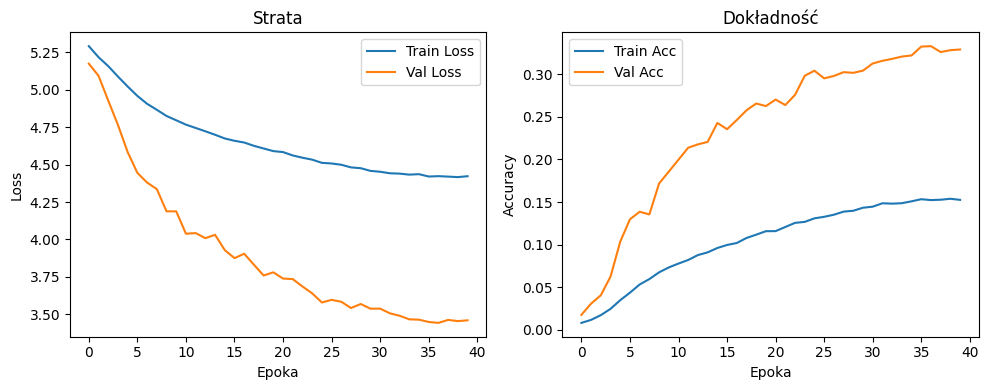

In [5]:
model = ResNet18V5Pro().to(device)
swa_model = AveragedModel(model)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

best_val_acc = 0.0
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

for epoch in range(40):
    print(f"\n🟢 Epoka {epoch+1}/40")
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total
    scheduler.step()

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_best.pt")
        print("✅ Zapisano najlepszy model!")

    swa_model.update_parameters(model)

# === Finalizacja SWA ===
update_bn(train_loader, swa_model, device=device)
torch.save(swa_model.module.state_dict(), f"{output_dir}/{model_name}_swa.pt")
print("📦 Zapisano model SWA")

# === Zapisywanie metryk ===
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f)

# === Wykresy ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.title("Strata")

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Dokładność")

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()


GOTOWE MODELE

Dry Eval: 100%|██████████| 157/157 [00:19<00:00,  7.95it/s]


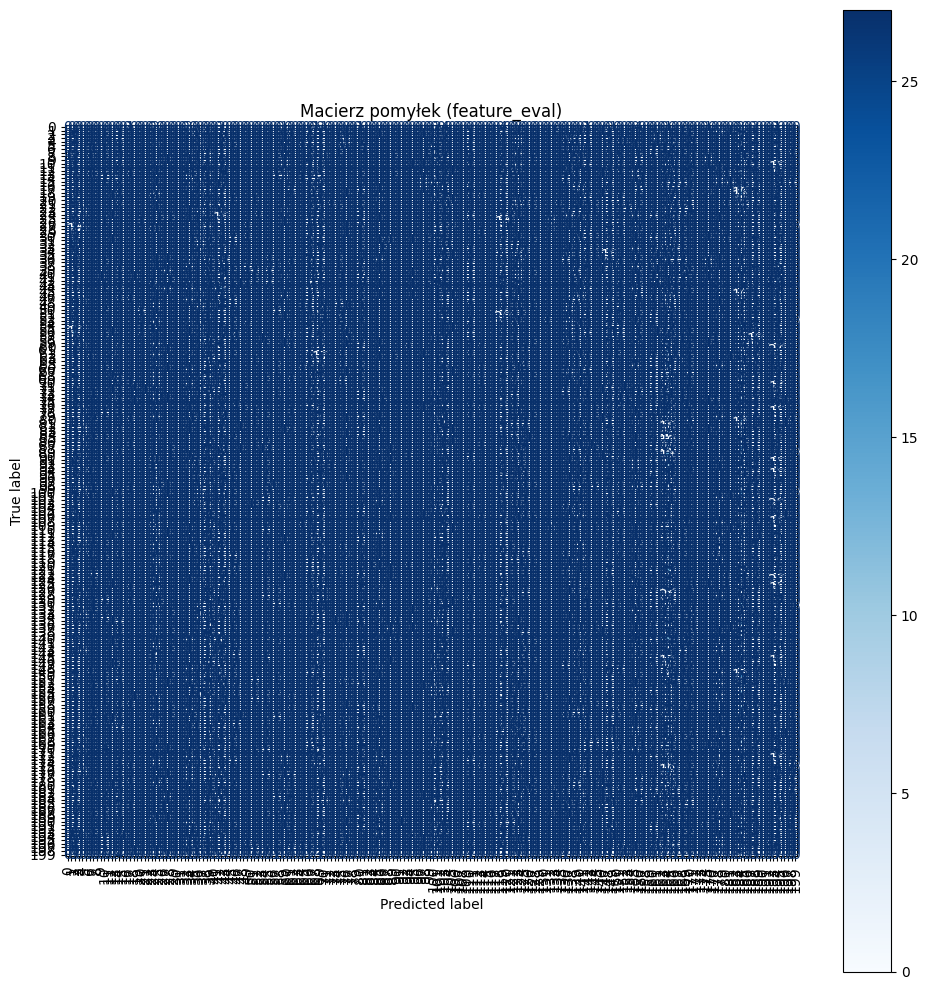


📊 Metryki dla resnet18 (feature_eval):
Accuracy : 0.0054
Precision: 0.0049
Recall   : 0.0054
F1-score : 0.0028


In [3]:
# resnet18 feature_eval z rozszerzonymi metrykami
import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

# === Ustawienia ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "resnet18"
output_dir = f"./outputs/{model_name}/feature_eval"
os.makedirs(output_dir, exist_ok=True)

# === Model ===
model = models.resnet18(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model = model.to(device)
model.eval()

# === Ewaluacja na zbiorze walidacyjnym ===
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Dry Eval"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# === Macierz pomyłek ===
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, xticks_rotation='vertical', cmap="Blues", values_format='d')
plt.title("Macierz pomyłek (feature_eval)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# === Statystyki ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"\n📊 Metryki dla {model_name} (feature_eval):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# === Raport klasyfikacji
report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)

# === Zapis metryk ===
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report
    }, f, indent=2)



🟢 Epoka 1/10


Train Loss: 3.3606 | Acc: 0.2812
Val   Loss: 3.2257 | Acc: 0.3108
✅ Zapisano najlepszy model!

🟢 Epoka 2/10


Train Loss: 2.9717 | Acc: 0.3427
Val   Loss: 3.1577 | Acc: 0.3251
✅ Zapisano najlepszy model!

🟢 Epoka 3/10


Train Loss: 2.9103 | Acc: 0.3520
Val   Loss: 3.2047 | Acc: 0.3262
✅ Zapisano najlepszy model!

🟢 Epoka 4/10


Train Loss: 2.8783 | Acc: 0.3578
Val   Loss: 3.2761 | Acc: 0.3180

🟢 Epoka 5/10


Train Loss: 2.8574 | Acc: 0.3627
Val   Loss: 3.2348 | Acc: 0.3296
✅ Zapisano najlepszy model!

🟢 Epoka 6/10


Train Loss: 2.8469 | Acc: 0.3626
Val   Loss: 3.2746 | Acc: 0.3226

🟢 Epoka 7/10


Train Loss: 2.8332 | Acc: 0.3660
Val   Loss: 3.2578 | Acc: 0.3272

🟢 Epoka 8/10


Train Loss: 2.8355 | Acc: 0.3651
Val   Loss: 3.2339 | Acc: 0.3315
✅ Zapisano najlepszy model!

🟢 Epoka 9/10


Train Loss: 2.8288 | Acc: 0.3671
Val   Loss: 3.2657 | Acc: 0.3256

🟢 Epoka 10/10


Train Loss: 2.8157 | Acc: 0.3698
Val   Loss: 3.2487 | Acc: 0.3290


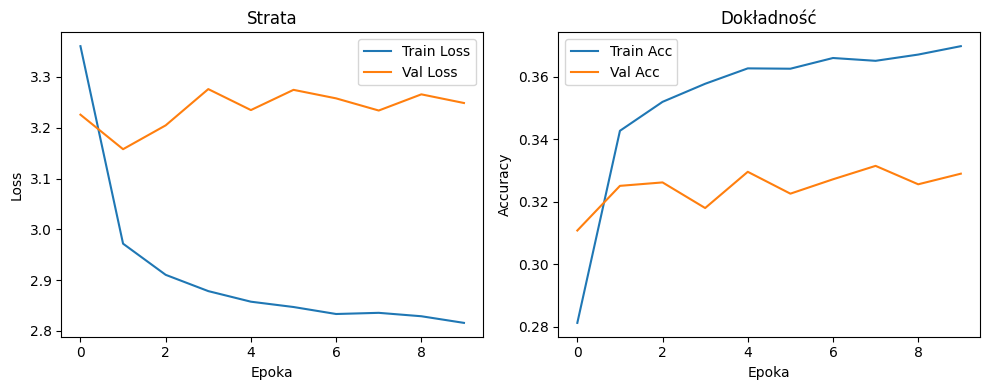


📊 Metryki końcowe (fc): Acc=0.3290 | Prec=0.3712 | Recall=0.3290 | F1=0.3225


In [ ]:
# Etap 2 — trening klasyfikatora (fc) przy zamrożonym backbone
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ustawienia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "resnet18"
stage = "classifier_train"
output_dir = f"./outputs/{model_name}/{stage}"
os.makedirs(output_dir, exist_ok=True)

# Model
model = models.resnet18(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False  # Zamrożenie wszystkiego...
model.fc = nn.Linear(model.fc.in_features, 200)  # ...poza fc
model.fc.requires_grad = True
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Trening
num_epochs = 20
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\n🟢 Epoka {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = total_loss / total
    train_acc = correct / total

    # Walidacja
    model.eval()
    val_preds, val_labels = [], []
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(1).cpu()
            val_preds.extend(preds.tolist())
            val_labels.extend(labels.tolist())
            total_loss += loss.item() * inputs.size(0)
            correct += (preds == labels.cpu()).sum().item()
            total += labels.size(0)

    val_loss = total_loss / total
    val_acc = correct / total
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_fc_best.pt")
        print("✅ Zapisano najlepszy model!")

# Metryki końcowe
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

# Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Macierz pomyłek
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, xticks_rotation='vertical', cmap="Blues", values_format='d')
plt.title("Macierz pomyłek (fc)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

# Zapis metryk
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

print(f"\n📊 Metryki końcowe (fc): Acc={acc:.4f} | Prec={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")


In [5]:
#Fine-tuning ResNet18 (pełny model + CutMix + LabelSmoothing + CosineLR)
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from torchvision import models

# === Konfiguracja ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "resnet18"
stage = "finetune_full"
output_dir = f"./outputs/{model_name}/{stage}"
os.makedirs(output_dir, exist_ok=True)

# === Model ===
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 200)
model = model.to(device)

# === Loss, optymalizator, scheduler ===
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

# === CutMix helper ===
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    rand_index = torch.randperm(x.size()[0]).to(device)
    y_a, y_b = y, y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_criterion(pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# === Trening ===
num_epochs = 40
best_val_acc = 0.0
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

for epoch in range(num_epochs):
    print(f"\n🟢 Epoka {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        if np.random.rand() < 0.5:
            inputs, y_a, y_b, lam = cutmix_data(inputs, labels)
            outputs = model(inputs)
            loss = cutmix_criterion(outputs, y_a, y_b, lam)
            correct += (lam * (outputs.argmax(1) == y_a).sum().item()
                        + (1 - lam) * (outputs.argmax(1) == y_b).sum().item())
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            correct += (outputs.argmax(1) == labels).sum().item()

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Walidacja
    model.eval()
    val_preds, val_labels = [], []
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(1).cpu()
            val_preds.extend(preds.tolist())
            val_labels.extend(labels.tolist())
            total_loss += loss.item() * inputs.size(0)
            correct += (preds == labels.cpu()).sum().item()

    val_loss = total_loss / len(val_labels)
    val_acc = correct / len(val_labels)

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_finetune_best.pt")
        print("✅ Zapisano najlepszy model!")

# === Metryki końcowe ===
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

# === Wykresy ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# === Macierz pomyłek ===
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, xticks_rotation='vertical', cmap="Blues", values_format='d')
plt.title("Macierz pomyłek (fine-tune)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

# === Zapis metryk ===
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

print(f"\n📊 Fine-tuning zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")



🟢 Epoka 1/40


Train Loss: 3.8270 | Acc: 0.2564
Val   Loss: 3.1594 | Acc: 0.3678
✅ Zapisano najlepszy model!

🟢 Epoka 2/40


Train Loss: 3.4335 | Acc: 0.3435
Val   Loss: 3.3533 | Acc: 0.3352

🟢 Epoka 3/40


KeyboardInterrupt: 

In [7]:
# === FEATURE EVAL RESNET50 ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "resnet50"
output_dir = f"./outputs/{model_name}/feature_eval"
os.makedirs(output_dir, exist_ok=True)

model = models.resnet50(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 200)
model = model.to(device)
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Dry Eval"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# Metryki
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)

# Zapis metryk i etykiet
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report
    }, f, indent=2)

with open(f"{output_dir}/true_labels.json", "w") as f:
    json.dump(all_labels, f)
with open(f"{output_dir}/predicted_labels.json", "w") as f:
    json.dump(all_preds, f)

# Macierz pomyłek
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", values_format="d")
plt.title(f"Confusion Matrix — {model_name} Feature Eval")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"✅ Dry eval {model_name} — Acc: {acc:.4f} | F1: {f1:.4f}")


Dry Eval: 100%|██████████| 157/157 [00:20<00:00,  7.60it/s]


✅ Dry eval resnet50 — Acc: 0.0066 | F1: 0.0032


In [ ]:
# === Etap 2: trening klasyfikatora FC (resnet50) ===
model_name = "resnet50"
stage = "train_fc"
output_dir = f"./outputs/{model_name}/{stage}"
os.makedirs(output_dir, exist_ok=True)

# === Model ===
model = models.resnet50(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 200)
model.fc.requires_grad = True
model = model.to(device)

# === Loss & optymalizator ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# === Trening ===
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0

for epoch in range(10):
    print(f"\n🟢 Epoka {epoch+1}/10")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Walidacja
    model.eval()
    val_preds, val_labels = [], []
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(1).cpu()
            val_preds.extend(preds.tolist())
            val_labels.extend(labels.tolist())
            total_loss += loss.item() * inputs.size(0)
            correct += (preds == labels.cpu()).sum().item()

    val_loss = total_loss / len(val_labels)
    val_acc = correct / len(val_labels)

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_fc_best.pt")
        print("✅ Zapisano najlepszy model!")

# === Wykresy ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# === Macierz pomyłek i metryki ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import json

cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, xticks_rotation='vertical', cmap="Blues", values_format='d')
plt.title("Macierz pomyłek (train_fc)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

# Po treningu fc — metryki końcowe
val_preds = np.array(val_preds)
val_labels = np.array(val_labels)

# Metryki
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

with open(f"{output_dir}/true_labels.json", "w") as f:
    json.dump(val_labels.tolist(), f)
with open(f"{output_dir}/predicted_labels.json", "w") as f:
    json.dump(val_preds.tolist(), f)

# Macierz pomyłek
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", values_format="d")
plt.title(f"Confusion Matrix — {model_name} train_fc")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"✅ Trening fc — Acc: {acc:.4f} | F1: {f1:.4f}")




🟢 Epoka 1/10


Train Loss: 3.1523 | Acc: 0.3323
Val   Loss: 3.2318 | Acc: 0.3509
✅ Zapisano najlepszy model!

🟢 Epoka 2/10


KeyboardInterrupt: 

In [9]:
import torch.nn.functional as F

model_name = "resnet50"
stage = "finetune_full"
output_dir = f"./outputs/{model_name}/{stage}"
os.makedirs(output_dir, exist_ok=True)

# === Model ===
model = models.resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 200)
model = model.to(device)

# === Loss, optymalizator, scheduler ===
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

# === CutMix ===
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    rand_index = torch.randperm(x.size()[0]).to(x.device)
    y_a, y_b = y, y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_criterion(pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# === Trening ===
num_epochs = 40
best_val_acc = 0.0
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

for epoch in range(num_epochs):
    print(f"\n🟢 Epoka {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Trening", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        if torch.rand(1).item() < 0.5:
            inputs, y_a, y_b, lam = cutmix_data(inputs, labels)
            outputs = model(inputs)
            loss = cutmix_criterion(outputs, y_a, y_b, lam)
            preds = outputs.argmax(1)
            correct += (lam * (preds == y_a).sum().item()
                        + (1 - lam) * (preds == y_b).sum().item())
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            correct += (outputs.argmax(1) == labels).sum().item()

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    model.eval()
    val_preds, val_labels = [], []
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(1).cpu()
            val_preds.extend(preds.tolist())
            val_labels.extend(labels.tolist())
            total_loss += loss.item() * inputs.size(0)
            correct += (preds == labels.cpu()).sum().item()

    val_loss = total_loss / len(val_labels)
    val_acc = correct / len(val_labels)

    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_finetune_best.pt")
        print("✅ Zapisano najlepszy model!")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json

# === Obliczenie metryk ===
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

# === Wykresy strat i dokładności ===
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# === Macierz pomyłek ===
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (Validation)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

# === Zapis metryk ===
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

# === Zapis etykiet (opcjonalnie) ===
with open(f"{output_dir}/true_labels.json", "w") as f:
    json.dump(val_labels.tolist(), f)
with open(f"{output_dir}/predicted_labels.json", "w") as f:
    json.dump(val_preds.tolist(), f)

# === Podsumowanie ===
print(f"\n📊 Fine-tune zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")



🟢 Epoka 1/40


Train Loss: 3.7876 | Acc: 0.2665
Val   Loss: 3.2822 | Acc: 0.3504
✅ Zapisano najlepszy model!

🟢 Epoka 2/40


KeyboardInterrupt: 

In [10]:
# === DRY EVAL: mobilenet_v3_large ===
import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

model_name = "mobilenet_v3_large"
output_dir = f"./outputs/{model_name}/feature_eval"
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v3_large(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 200)
model = model.to(device)
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Dry Eval"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# Metryki
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)

# Zapis
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report
    }, f, indent=2)

with open(f"{output_dir}/true_labels.json", "w") as f:
    json.dump(all_labels, f)
with open(f"{output_dir}/predicted_labels.json", "w") as f:
    json.dump(all_preds, f)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", values_format="d")
plt.title("Confusion Matrix — mobilenet_v3_large (Dry Eval)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"✅ Dry eval mobilenet_v3_large — Accuracy: {acc:.4f} | F1: {f1:.4f}")


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\msigm/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 89.3MB/s]
Dry Eval: 100%|██████████| 157/157 [00:19<00:00,  8.22it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024054692160>
Traceback (most recent call last):
  File "c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


✅ Dry eval mobilenet_v3_large — Accuracy: 0.0053 | F1: 0.0037


In [11]:
# === TRAIN FC: mobilenet_v3_large ===
import torch.optim as optim

model_name = "mobilenet_v3_large"
output_dir = f"./outputs/{model_name}/train_fc"
os.makedirs(output_dir, exist_ok=True)

# Freeze everything except classifier
model = models.mobilenet_v3_large(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 200)
model.classifier[3].requires_grad = True
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[3].parameters(), lr=0.001)

train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0
val_preds, val_labels = [], []

for epoch in range(10):
    print(f"\n🔄 Epoka {epoch+1}/10")
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss_all.append(total_loss / total)
    train_acc_all.append(correct / total)

    # Eval
    model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    val_loss_all.append(total_loss / total)
    val_acc = correct / total
    val_acc_all.append(val_acc)

    print(f"Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_fc_best.pt")
        print("✅ Zapisano najlepszy model!")



🔄 Epoka 1/10


Train Acc: 0.1646 | Val Acc: 0.1739
✅ Zapisano najlepszy model!

🔄 Epoka 2/10


KeyboardInterrupt: 

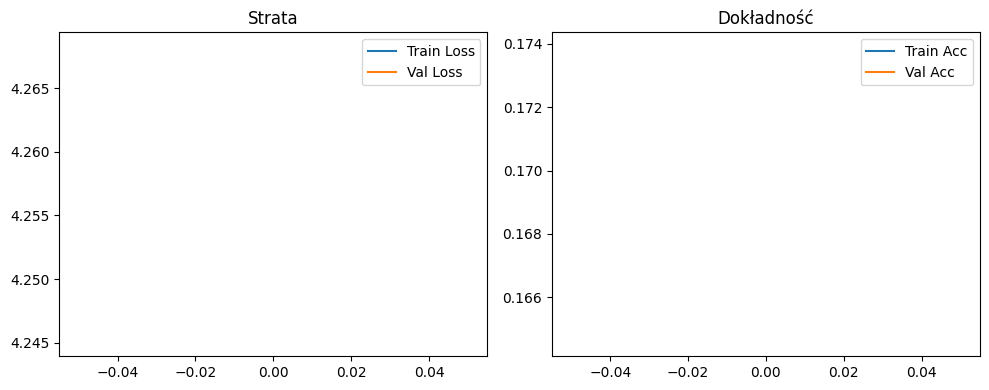


📊 Trening fc zakończony — Accuracy: 0.1739 | F1: 0.1649


In [12]:
# === METRYKI & ZAPIS ===
from sklearn.metrics import classification_report

acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

# wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# confusion matrix
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (fc)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

with open(f"{output_dir}/true_labels.json", "w") as f:
    json.dump(val_labels, f)
with open(f"{output_dir}/predicted_labels.json", "w") as f:
    json.dump(val_preds, f)

print(f"\n📊 Trening fc zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")


In [13]:
# === FINE-TUNE FULL MODEL: mobilenet_v3_large ===
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

model_name = "mobilenet_v3_large"
output_dir = f"./outputs/{model_name}/finetune_full"
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = models.mobilenet_v3_large(weights="IMAGENET1K_V1")
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 200)
for param in model.parameters():
    param.requires_grad = True  # odblokowanie wszystkich warstw
model = model.to(device)

# Optymalizacja
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Metryki
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0
val_preds, val_labels = [], []

# Trening
for epoch in range(20):
    print(f"\n🚀 Epoka {epoch+1}/20")
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss_all.append(total_loss / total)
    train_acc_all.append(correct / total)

    # Walidacja
    model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    val_loss_all.append(total_loss / total)
    val_acc = correct / total
    val_acc_all.append(val_acc)
    scheduler.step()

    print(f"📊 Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_finetuned_best.pt")
        print("✅ Zapisano najlepszy model!")

# === Zapis metryk i wykresów ===
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

# Wykres
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (fine-tune)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"\n✅ Fine-tune zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")



🚀 Epoka 1/20


📊 Train Acc: 0.2794 | Val Acc: 0.3674
✅ Zapisano najlepszy model!

🚀 Epoka 2/20


KeyboardInterrupt: 

In [14]:
# === DRY EVAL: efficientnet_b0 ===
import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

model_name = "efficientnet_b0"
output_dir = f"./outputs/{model_name}/feature_eval"
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 200)
model = model.to(device)
model.eval()

# Dry eval
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Dry Eval"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# Metryki
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)

# Zapis
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report
    }, f, indent=2)

with open(f"{output_dir}/true_labels.json", "w") as f:
    json.dump(all_labels, f)
with open(f"{output_dir}/predicted_labels.json", "w") as f:
    json.dump(all_preds, f)

# Macierz pomyłek
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", values_format="d")
plt.title("Confusion Matrix — efficientnet_b0 (Dry Eval)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"✅ Dry eval {model_name} — Accuracy: {acc:.4f} | F1: {f1:.4f}")


Dry Eval: 100%|██████████| 157/157 [00:40<00:00,  3.92it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024054692160>
Traceback (most recent call last):
  File "c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
  File "c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


✅ Dry eval efficientnet_b0 — Accuracy: 0.0059 | F1: 0.0052


In [15]:
# === TRAIN FC: efficientnet_b0 ===
import torch.optim as optim

model_name = "efficientnet_b0"
output_dir = f"./outputs/{model_name}/train_fc"
os.makedirs(output_dir, exist_ok=True)

# Model
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 200)
model.classifier[1].requires_grad = True
model = model.to(device)

# Optymalizacja
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-3)

# Statystyki
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0
val_preds, val_labels = [], []

# Trening klasyfikatora
for epoch in range(10):
    print(f"\n🔄 Epoka {epoch+1}/10")
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss_all.append(total_loss / total)
    train_acc_all.append(correct / total)

    # Walidacja
    model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    val_loss_all.append(total_loss / total)
    val_acc = correct / total
    val_acc_all.append(val_acc)

    print(f"📊 Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_fc_best.pt")
        print("✅ Zapisano najlepszy model!")

# === METRYKI I ZAPIS ===
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

# Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Macierz pomyłek
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (train_fc)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"\n✅ Train FC zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")



🔄 Epoka 1/10


📊 Train Acc: 0.2128 | Val Acc: 0.1995
✅ Zapisano najlepszy model!

🔄 Epoka 2/10


KeyboardInterrupt: 

In [16]:
# === FINETUNE FULL: efficientnet_b0 ===
import torch.optim as optim

model_name = "efficientnet_b0"
output_dir = f"./outputs/{model_name}/finetune_full"
os.makedirs(output_dir, exist_ok=True)

# Model
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 200)
model = model.to(device)

# Optymalizacja
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Statystyki
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0
val_preds, val_labels = [], []

for epoch in range(20):
    print(f"\n🟢 Epoka {epoch+1}/20")
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss_all.append(total_loss / total)
    train_acc_all.append(correct / total)

    # Walidacja
    model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    val_loss_all.append(total_loss / total)
    val_acc = correct / total
    val_acc_all.append(val_acc)
    scheduler.step()

    print(f"📊 Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_finetune_best.pt")
        print("✅ Zapisano najlepszy model!")

# === METRYKI I ZAPIS ===
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

# Wykresy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

# Macierz pomyłek
cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (finetune_full)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"\n✅ Finetune zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")



🟢 Epoka 1/20


📊 Train Acc: 0.3860 | Val Acc: 0.3827
✅ Zapisano najlepszy model!

🟢 Epoka 2/20


KeyboardInterrupt: 

In [17]:
# === DRY EVAL: densenet121 ===
import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

model_name = "densenet121"
output_dir = f"./outputs/{model_name}/feature_eval"
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(model.classifier.in_features, 200)
model = model.to(device)
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Dry Eval"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# Metryki
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)

# Zapis
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report
    }, f, indent=2)

with open(f"{output_dir}/true_labels.json", "w") as f:
    json.dump(all_labels, f)
with open(f"{output_dir}/predicted_labels.json", "w") as f:
    json.dump(all_preds, f)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", values_format="d")
plt.title("Confusion Matrix — densenet121 (Dry Eval)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"✅ Dry eval densenet121 — Accuracy: {acc:.4f} | F1: {f1:.4f}")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\msigm/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 33.2MB/s]
Dry Eval: 100%|██████████| 157/157 [00:41<00:00,  3.77it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024054692160>
Traceback (most recent call last):
  File "c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
  File "c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


✅ Dry eval densenet121 — Accuracy: 0.0043 | F1: 0.0025


In [18]:
# === TRAIN FC: densenet121 ===
import torch.optim as optim

model_name = "densenet121"
output_dir = f"./outputs/{model_name}/train_fc"
os.makedirs(output_dir, exist_ok=True)

# Model
model = models.densenet121(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(model.classifier.in_features, 200)
model.classifier.requires_grad = True
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0
val_preds, val_labels = [], []

for epoch in range(10):
    print(f"\n🔄 Epoka {epoch+1}/10")
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss_all.append(total_loss / total)
    train_acc_all.append(correct / total)

    # Walidacja
    model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    val_loss_all.append(total_loss / total)
    val_acc = correct / total
    val_acc_all.append(val_acc)

    print(f"Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_fc_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis statystyk + wykresy + metryki
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.title("Strata")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.title("Dokładność")
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (train_fc)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"\n📊 Trenowanie FC zakończone — Accuracy: {acc:.4f} | F1: {f1:.4f}")



🔄 Epoka 1/10


Train Acc: 0.3337 | Val Acc: 0.3783
✅ Zapisano najlepszy model!

🔄 Epoka 2/10


KeyboardInterrupt: 

In [19]:
# === FINE-TUNE: densenet121 ===
import torch.optim as optim

model_name = "densenet121"
output_dir = f"./outputs/{model_name}/finetune"
os.makedirs(output_dir, exist_ok=True)

# Model
model = models.densenet121(weights="IMAGENET1K_V1")
model.classifier = nn.Linear(model.classifier.in_features, 200)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0
val_preds, val_labels = [], []

for epoch in range(20):
    print(f"\n🔄 Epoka {epoch+1}/20")
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss_all.append(total_loss / total)
    train_acc_all.append(correct / total)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    val_loss_all.append(total_loss / total)
    val_acc = correct / total
    val_acc_all.append(val_acc)
    scheduler.step()

    print(f"Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_finetuned_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis metryk
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (fine-tune)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"\n📊 Fine-tune zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")



🔄 Epoka 1/20


Train Acc: 0.4090 | Val Acc: 0.4381
✅ Zapisano najlepszy model!

🔄 Epoka 2/20


KeyboardInterrupt: 

In [ ]:
# === DRY EVAL: efficientnet_b0 ===
import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

model_name = "efficientnet_b0"
output_dir = f"./outputs/{model_name}/feature_eval"
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 200)
model = model.to(device)
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Dry Eval"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# Metryki
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)

# Zapis
with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report
    }, f, indent=2)

with open(f"{output_dir}/true_labels.json", "w") as f:
    json.dump(all_labels, f)
with open(f"{output_dir}/predicted_labels.json", "w") as f:
    json.dump(all_preds, f)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", values_format="d")
plt.title("Confusion Matrix — efficientnet_b0 (Dry Eval)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"✅ Dry eval {model_name} — Accuracy: {acc:.4f} | F1: {f1:.4f}")


Dry Eval: 100%|██████████| 157/157 [00:39<00:00,  4.02it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024054692160>
Traceback (most recent call last):
  File "c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
  File "c:\Users\msigm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [ ]:
# === TRAIN FC: efficientnet_b0 ===
import torch.optim as optim

model_name = "efficientnet_b0"
output_dir = f"./outputs/{model_name}/train_fc"
os.makedirs(output_dir, exist_ok=True)

model = models.efficientnet_b0(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 200)
model.classifier[1].requires_grad = True
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0
val_preds, val_labels = [], []

for epoch in range(10):
    print(f"\n🔄 Epoka {epoch+1}/10")
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss_all.append(total_loss / total)
    train_acc_all.append(correct / total)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    val_loss_all.append(total_loss / total)
    val_acc = correct / total
    val_acc_all.append(val_acc)

    print(f"Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_fc_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis metryk
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (train_fc)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"\n📊 Train FC zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")


In [ ]:
# === FINETUNE: efficientnet_b0 ===
import torch.optim as optim

model_name = "efficientnet_b0"
output_dir = f"./outputs/{model_name}/finetune"
os.makedirs(output_dir, exist_ok=True)

model = models.efficientnet_b0(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 200)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
best_val_acc = 0.0
val_preds, val_labels = [], []

for epoch in range(20):
    print(f"\n🌍 Epoka {epoch+1}/20")
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss_all.append(total_loss / total)
    train_acc_all.append(correct / total)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())
    val_loss_all.append(total_loss / total)
    val_acc = correct / total
    val_acc_all.append(val_acc)
    scheduler.step()

    print(f"Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{output_dir}/{model_name}_finetune_best.pt")
        print("✅ Zapisano najlepszy model!")

# Zapis metryk
acc = accuracy_score(val_labels, val_preds)
prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

with open(f"{output_dir}/metrics.json", "w") as f:
    json.dump({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": report,
        "train_loss": train_loss_all,
        "val_loss": val_loss_all,
        "train_acc": train_acc_all,
        "val_acc": val_acc_all
    }, f, indent=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.title("Strata")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all, label='Train Acc')
plt.plot(val_acc_all, label='Val Acc')
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/training_plot.png")
plt.show()

cm = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
plt.title("Macierz pomyłek (finetune)")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.close()

print(f"\n📊 Fine-tune zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lista modeli do przetestowania
model_names = [
    "resnet18",
    "resnet50",
    "mobilenet_v3_large",
    "efficientnet_b0",
    "efficientnet_b3",
    "densenet121",
    "convnext_tiny",
    "swin_t",
    "vit_b_16",
    "regnet_y_400mf"
]

for model_name in model_names:
    print(f"\n🚀 DRY EVAL: {model_name}")

    output_dir = f"./outputs/{model_name}/feature_eval"
    os.makedirs(output_dir, exist_ok=True)

    # Wczytaj model z wagami
    model = getattr(models, model_name)(weights="IMAGENET1K_V1")
    # Zamiana ostatniej warstwy na 200-klasową
    if "resnet" in model_name or "regnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, 200)
    elif "densenet" in model_name:
        model.classifier = nn.Linear(model.classifier.in_features, 200)
    elif "mobilenet" in model_name or "efficientnet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 200)
    elif "convnext" in model_name or "swin" in model_name or "vit" in model_name:
        model.head = nn.Linear(model.head.in_features, 200)
    else:
        raise ValueError(f"Nieznany typ modelu: {model_name}")

    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Dry Eval {model_name}"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # Metryki
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)

    # Zapis metryk
    with open(f"{output_dir}/metrics.json", "w") as f:
        json.dump({
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "classification_report": report
        }, f, indent=2)

    with open(f"{output_dir}/true_labels.json", "w") as f:
        json.dump(all_labels, f)
    with open(f"{output_dir}/predicted_labels.json", "w") as f:
        json.dump(all_preds, f)

    # Macierz pomyłek
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", values_format="d")
    plt.title(f"Confusion Matrix — {model_name} (Dry Eval)")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/confusion_matrix.png")
    plt.close()

    print(f"✅ {model_name}: Acc={acc:.4f}, F1={f1:.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = [
    "resnet18",
    "resnet50",
    "mobilenet_v3_large",
    "efficientnet_b0",
    "efficientnet_b3",
    "densenet121",
    "convnext_tiny",
    "swin_t",
    "vit_b_16",
    "regnet_y_400mf"
]

for model_name in model_names:
    print(f"\n🔁 TRAIN FC: {model_name}")
    output_dir = f"./outputs/{model_name}/train_fc"
    os.makedirs(output_dir, exist_ok=True)

    # Model + classifier
    model = getattr(models, model_name)(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False

    if "resnet" in model_name or "regnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, 200)
        classifier_params = model.fc.parameters()
    elif "densenet" in model_name:
        model.classifier = nn.Linear(model.classifier.in_features, 200)
        classifier_params = model.classifier.parameters()
    elif "mobilenet" in model_name or "efficientnet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 200)
        classifier_params = model.classifier[-1].parameters()
    elif "convnext" in model_name or "swin" in model_name or "vit" in model_name:
        model.head = nn.Linear(model.head.in_features, 200)
        classifier_params = model.head.parameters()
    else:
        raise ValueError(f"Nieznany model: {model_name}")

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier_params, lr=0.001)

    train_loss_all, val_loss_all = [], []
    train_acc_all, val_acc_all = [], []
    best_val_acc = 0.0
    val_preds, val_labels = [], []

    for epoch in range(10):
        print(f"\n🟢 Epoka {epoch+1}/10")
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss_all.append(total_loss / total)
        train_acc_all.append(correct / total)

        # Eval
        model.eval()
        total_loss, correct, total = 0, 0, 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                val_preds.extend(preds.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())
        val_loss_all.append(total_loss / total)
        val_acc = correct / total
        val_acc_all.append(val_acc)

        print(f"Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{output_dir}/{model_name}_fc_best.pt")
            print("✅ Zapisano najlepszy model!")

    # Metryki
    acc = accuracy_score(val_labels, val_preds)
    prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

    with open(f"{output_dir}/metrics.json", "w") as f:
        json.dump({
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "classification_report": report,
            "train_loss": train_loss_all,
            "val_loss": val_loss_all,
            "train_acc": train_acc_all,
            "val_acc": val_acc_all
        }, f, indent=2)

    # Wykresy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_all, label='Train Loss')
    plt.plot(val_loss_all, label='Val Loss')
    plt.title("Strata")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_all, label='Train Acc')
    plt.plot(val_acc_all, label='Val Acc')
    plt.title("Dokładność")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/training_plot.png")
    plt.close()

    # Macierz pomyłek
    cm = confusion_matrix(val_labels, val_preds)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
    plt.title(f"Macierz pomyłek — {model_name} (Train FC)")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/confusion_matrix.png")
    plt.close()

    print(f"📊 {model_name} FC train done — Accuracy: {acc:.4f} | F1: {f1:.4f}")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

# === Ustawienia ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_names = [
    "resnet18",
    "resnet50",
    "mobilenet_v3_large",
    "efficientnet_b0",
    "efficientnet_b3",
    "densenet121",
    "convnext_tiny",
    "swin_t",
    "vit_b_16",
    "regnet_y_400mf"
]

for model_name in model_names:
    print(f"\n🔁 FULL FINE-TUNING: {model_name}")
    output_dir = f"./outputs/{model_name}/finetune"
    os.makedirs(output_dir, exist_ok=True)

    # === Model ===
    model = getattr(models, model_name)(weights="IMAGENET1K_V1")
    if "resnet" in model_name or "regnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, 200)
    elif "densenet" in model_name:
        model.classifier = nn.Linear(model.classifier.in_features, 200)
    elif "mobilenet" in model_name or "efficientnet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 200)
    elif "convnext" in model_name or "swin" in model_name or "vit" in model_name:
        model.head = nn.Linear(model.head.in_features, 200)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

    train_loss_all, val_loss_all = [], []
    train_acc_all, val_acc_all = [], []
    best_val_acc = 0.0

    for epoch in range(20):
        print(f"\n🟢 Epoka {epoch+1}/20")
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss_all.append(total_loss / total)
        train_acc_all.append(correct / total)

        model.eval()
        total_loss, correct, total = 0, 0, 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                val_preds.extend(preds.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())
        val_loss_all.append(total_loss / total)
        val_acc = correct / total
        val_acc_all.append(val_acc)
        scheduler.step()

        print(f"Train Acc: {train_acc_all[-1]:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{output_dir}/{model_name}_finetune_best.pt")
            print("✅ Zapisano najlepszy model!")

    # === Metryki & zapis ===
    acc = accuracy_score(val_labels, val_preds)
    prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

    with open(f"{output_dir}/metrics.json", "w") as f:
        json.dump({
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "classification_report": report,
            "train_loss": train_loss_all,
            "val_loss": val_loss_all,
            "train_acc": train_acc_all,
            "val_acc": val_acc_all
        }, f, indent=2)

    # Wykresy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_all, label='Train Loss')
    plt.plot(val_loss_all, label='Val Loss')
    plt.title("Strata")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_all, label='Train Acc')
    plt.plot(val_acc_all, label='Val Acc')
    plt.title("Dokładność")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/training_plot.png")
    plt.close()

    cm = confusion_matrix(val_labels, val_preds)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical', values_format='d')
    plt.title(f"Macierz pomyłek — {model_name} (Fine-tune)")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/confusion_matrix.png")
    plt.close()

    print(f"📊 {model_name} — Fine-tune zakończony — Accuracy: {acc:.4f} | F1: {f1:.4f}")
